# Optimization: finding Rastrigin global minimum

In this notebook we will show how to use [Auxein](https://github.com/auxein/auxein) to find a global minimum of a function.

In this particular case we will use the 3-dimensional version of the [Rastrigin](https://en.wikipedia.org/wiki/Rastrigin_function) $R(x, y) = z$.

The Rastrigin function is particularly interesting for optimisation problems because it is made of several local minum and one global maxium.
So, given the Rastringing function $R(x, y) = z$, our goal will be finding $x$ and $y$ such as $R(x, y) = 0$.

In [1]:
import numpy as np
import logging

logging.getLogger().setLevel(logging.CRITICAL)

As a first thing, let's define the Rastrigin function as below:

In [2]:
def rastrigin(X, A = 10):
    return A*len(X) + sum([(x**2 - A * np.cos(2 * np.pi * x)) for x in X])

Then let's plot the function:

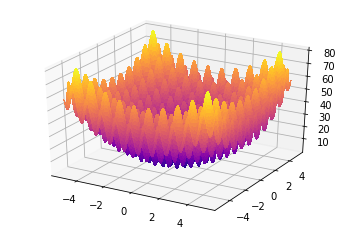

In [3]:
%matplotlib inline  

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.pyplot as plt
import numpy as np



X = np.linspace(-5.12, 5.12, 200)    
Y = np.linspace(-5.12, 5.12, 200)    

X, Y = np.meshgrid(X, Y)

Z = rastrigin([X, Y])

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)    

Then, let's wrap the function with an Auxein [Fitness function](https://github.com/auxein/auxein/blob/master/auxein/fitness/core.py#L15). 

Auxein comes with some pre-defined fitness functions. In our case, given that we want to find the minium of the Rastrin function, we can use the `GlobalMinimum` function to wrap the function we want to minimise:

In [ ]:
from auxein.fitness.kernel_based import GlobalMinimum
fitness_function = GlobalMinimum(rastrigin)

Then, the second step is to create an initial `population` of individuals. 

Each `individual` maps to candidate solution, which in this case would be a vector $(x, y)$. Auxein provides some utility functions to create initial populations, like the `build_fixed_dimension_population` used below.

Is probably worth noting as we will use a `NormalRandomDnaBuilder` to have the initial population of individuals scattered around the solution space but centered around $(0, 0)$

In [5]:
from auxein.population.dna_builders import NormalRandomDnaBuilder
from auxein.population import build_fixed_dimension_population
population = build_fixed_dimension_population(2, 200, fitness_function, NormalRandomDnaBuilder(0, 1.5))

Once we have a `fitness_function` $\phi(x,y)$ and an initial `population`, we need to set up a [Playground](https://github.com/auxein/auxein/blob/master/auxein/playgrounds/static.py#L27).
A playground is basically the object that represents our experiment.

In [6]:
from auxein.playgrounds import Static
from auxein.mutations import SelfAdaptiveSingleStep
from auxein.recombinations import SimpleArithmetic
from auxein.parents.distributions import SigmaScaling
from auxein.parents.selections import StochasticUniversalSampling
from auxein.replacements import ReplaceWorst

In order to instantiate a `playground` the following must be specified:
* `mutation` strategy, which describes how `individual` dna will mutate. In this case we will use the [SelfAdaptiveSingleStep](https://github.com/auxein/auxein/blob/master/auxein/mutations/core.py#L62).
* parents `distribution`, which gives a probability distribution for parents `selection`. We here use [SigmaScaling](https://github.com/auxein/auxein/blob/master/auxein/parents/distributions/core.py#L43) for distribution and [StochasticUniversalSampling](https://github.com/auxein/auxein/blob/master/auxein/parents/selections/core.py#L27) for selection.
* `recombination` defines how fresh dna are created when `individual`s breed. Here we use the basic [SimpleArithmetic](https://github.com/auxein/auxein/blob/master/auxein/recombinations/core.py#L23).
* for `replacement` we will use the basic [ReplaceWorst](https://github.com/auxein/auxein/blob/master/auxein/replacements/core.py#L34) which basically only replaces the 2-worst performing individuals.

In [7]:
offspring_size = 4
playground = Static(
    population = population,
    fitness = fitness_function,
    mutation = SelfAdaptiveSingleStep(0.1),
    distribution = SigmaScaling(),
    selection = StochasticUniversalSampling(offspring_size = offspring_size),
    recombination = SimpleArithmetic(alpha = 0.5),
    replacement = ReplaceWorst(offspring_size = offspring_size)
)

Invoking `playground.train(max_generations = )` will trigger the evolution process up to a maximum of $500$ generations.

In [8]:
stats = playground.train(500)

INFO:root:Starting evolution cycle with a maximum of 500 generations
INFO:root:Training ended with average_fitness: -0.6299824766641763


Once the training has ended, to get the most performant `individual` we can invoke `playground.get_most_performant()` and grab the dna of the individual.

In [9]:
[x, y] = playground.get_most_performant().genotype.dna

In [10]:
x

0.0064642078203482395

In [11]:
y

-0.002448669908469602

Which we can use to evaluate the `rastrigin` function:

In [12]:
rastrigin([x, y])

0.00947840704530023

It would be also useful to see how the mean fitness value changed over the generations. Intuitively, an increasing mean fitness might indicate that the evolution process is selecting better solutions for our problem.

This is possible using the `stats` dictionary returned by the `Playground` at the end of the training session.

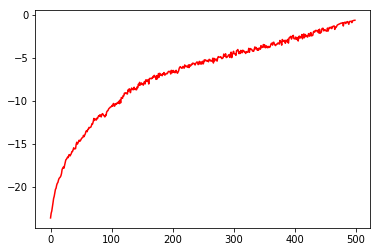

In [13]:
mean_fitness_values = []
for g in stats['generations'].values():
    mean_fitness_values.append(g['mean_fitness'])

plt.plot(stats['generations'].keys(), mean_fitness_values, color='red');

## Fitness landscape exploration

For a better understanding of how an evolutionary algorithm works, it might be useful to show how a population "moves" across generations to get "around" or "close" a local optimum in the [fitness landscape](https://en.wikipedia.org/wiki/Fitness_landscape).

In fact, each individual carries a dna of the shape $(x, y)$, which can be mapped to a value in the fitness landscape with $\phi(x,y) = f_0$.

In [25]:
size = 200
landscape = fitness_function.get_landscape([[-5.12, 5.12], [-5.12, 5.12]], size)

A = landscape.T[0].reshape(size, size)
B = landscape.T[1].T.reshape(size, size)
F = landscape.T[2].T.reshape(size, size)

It might be interesting to see where the population as a whole is positioned in the landscape at the **last** generation, as depicted below:

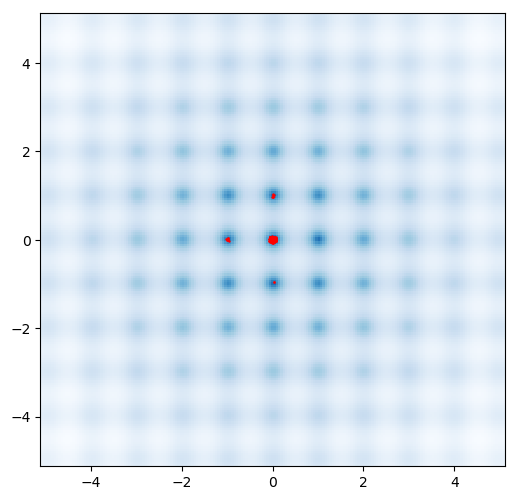

In [29]:
import matplotlib.colors as colors

plt.figure(figsize=(6, 6), dpi=100)
plt.pcolormesh(
    A,
    B,
    F,
    cmap=plt.cm.get_cmap('Blues'),
    norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=F.min(), vmax=F.max())
)
for dna in stats['generations'][499]['genome']:
    plt.scatter(dna[0], dna[1], marker='o', color="red", s=0.5)

As expected, the largest part of the population is concentrated within the global minimum of the function.

Finally, we can use the following code to get the landscape from the `fitness_function` for a given interval toproduce an image for each generation and then plotting the position of every individual of that generation. 

Then we combine all of them in a animated gif.

In [15]:
import os
os.mkdir('landscape_frames')

In [16]:
for generation in stats['generations'].keys():
    plt.figure(figsize=(8, 8), dpi=100)
    plt.pcolormesh(
        A,
        B,
        F,
        cmap=plt.cm.get_cmap('Blues'),
        norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=F.min(), vmax=F.max())
    )
    for dna in stats['generations'][generation]['genome']:
        if (A.min() <= dna[0] <= A.max()) and (B.min() <= dna[1] <= B.max()):
            plt.scatter(dna[0], dna[1], marker='o', color="red", s=0.5)
    plt.savefig(f'landscape_frames/{generation}.png')